# Libraries & Custom functions

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader
from tqdm import tqdm

# Ignore UserWarning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Exercise 1

## Exercise 1. (A)

### References
 - https://www.analyticsvidhya.com/blog/2023/01/gradient-descent-vs-backpropagation-whats-the-difference/#:~:text=To%20put%20it%20plainly%2C%20gradient,gradient%20descent%20relies%20on%20backpropagation.

**Backpropagation** and **gradient descent** are like a dynamic duo in training deep neural networks (DNNs).

**Backpropagation** is the process of computing the partial derivatives of the network's parameters with respect to the loss function, in a backward manner. It's all about figuring out how much each parameter contributed to the error, layer by layer, starting from the output layer and working backward through the network. For that, it's crucial to understand the computational graph and the dependencies of each component of the network, for example the activation values. This info helps adjust the network's parameters so to minimize its cost, info that is used for gradient descent.

Now, **gradient descent** is the optimization technique that works hand-in-hand with backpropagation. It's all about finding the (local or global) minimum of the loss function. The gradient (derivative) of the loss with respect to the parameters tells us the direction of the steepest increase. Gradient descent takes steps in the opposite direction to minimize the loss. In order to control how fast or slow the network optimizes its parameters, a learning rate is used, being multiplied with the gradients, and because this is a minimization problem, the old parameters are subtracted by the adjusted gradient of the respective parameters.

So, to sum it up, backpropagation computes the gradients of the network's parameters, while gradient descent uses those gradients to minimize the loss function. They team up to make our neural networks smarter!

## Exercise 1. (B)

### References
 - https://towardsdatascience.com/nothing-but-numpy-understanding-creating-binary-classification-neural-networks-with-e746423c8d5c

In [2]:
def BCE_Loss(y_true, y_hat):
    if y_true == y_hat:
        return torch.tensor(0.)

    return -1 * (y_true * torch.log(y_hat) + (1 - y_true) * torch.log(1 - y_hat))


def ForwardPass(X, W, b = 0):

    z1 = torch.matmul(X, W[0].T) + b
    a1 = F.relu(z1)

    z2 = torch.matmul(a1, W[1].T) + b
    a2 = F.leaky_relu(z2, negative_slope = 0.01)

    z3 = torch.matmul(a2, W[2].T) + b
    a3 = F.sigmoid(z3)

    return a3, a2, a1


def BackwardPass(X, a1, a2, a3, y_true, W):

    # Partial derivative of the loss function with respect to the prediction
    dL_da3 = -1 * (y_true / a3 - (1 - y_true) / (1 - a3)) if y_true != a3 else torch.tensor([0.])
    # Partial derivative of the loss function with respect to z3, using the sigmoid derivative
    dL_dz3 = dL_da3 * (a3 * (1 - a3))
    # Partial derivative of the loss function with respect to the weights of the connections between the second hidden layer and the output layer
    dL_dW3 = torch.matmul(dL_dz3.T, a2)

    # Partial derivative of the loss function with respect to the activation values from the second hidden layer
    dL_da2 = torch.matmul(dL_dz3, W[2])
    # Partial derivative of the loss function with respect to z2, using the Leaky ReLU derivative
    dL_dz2 = torch.where(a2 >= 0, dL_da2, 0.01 * dL_da2)
    # Partial derivative of the loss function with respect to the weights of the connections between the first and second hidden layers
    dL_dW2 = torch.matmul(dL_dz2.T, a1)

    # Partial derivative of the loss function with respect to the activation values from the first hidden layer
    dL_da1 = torch.matmul(dL_dz2, W[1])
    # Partial derivative of the loss function with respect to z2, using the ReLU derivative
    dL_dz1 = torch.where(a1 >= 0, dL_da1, 0.0 * dL_da1)
    # Partial derivative of the loss function with respect to the weights of the connections between the input layer and the first hidden layers
    dL_dW1 = torch.matmul(dL_dz1.T, X)

    return dL_dW1, dL_dW2, dL_dW3


def StochasticGradientDescent(dL_dW1, dL_dW2, dL_dW3, W, lr):
    # Update weights using SGD
    W[0] -= lr * dL_dW1
    W[1] -= lr * dL_dW2
    W[2] -= lr * dL_dW3

    return W

In [3]:
input_values = torch.tensor([[5., 4., 1., 3., 2.]])

y_true = torch.tensor([1.])

w1 = torch.tensor([[0.2, 0.2, 0.2, 0.2, 0.2],
                   [0.2, 0.2, 0.2, 0.2, 0.2],
                   [0.2, 0.2, 0.2, 0.2, 0.2]])

w2 = torch.tensor([[0.2, 0.2, 0.2],
                   [0.2, 0.2, 0.2]])

w3 = torch.tensor([[0.2, 0.2]])

W = list([w1, w2, w3])

In [4]:
a3, a2, a1 = ForwardPass(input_values, W)
loss = BCE_Loss(y_true, a3)

print("Predicted Output (a3):", a3.item())
print("Expected Output (y_true):", y_true.item())
print("Binary Cross-Entropy Loss:", loss.item())

Predicted Output (a3): 0.6726070046424866
Expected Output (y_true): 1.0
Binary Cross-Entropy Loss: 0.3965940773487091


In [5]:
dL_dW1, dL_dW2, dL_dW3 = BackwardPass(input_values, a1, a2, a3, y_true, W)

print("dL_dW1:", dL_dW1)
print("dL_dW2:", dL_dW2)
print("dL_dW3:", dL_dW3)

dL_dW1: tensor([[-0.1310, -0.1048, -0.0262, -0.0786, -0.0524],
        [-0.1310, -0.1048, -0.0262, -0.0786, -0.0524],
        [-0.1310, -0.1048, -0.0262, -0.0786, -0.0524]])
dL_dW2: tensor([[-0.1964, -0.1964, -0.1964],
        [-0.1964, -0.1964, -0.1964]])
dL_dW3: tensor([[-0.5893, -0.5893]])


In [6]:
W = StochasticGradientDescent(dL_dW1, dL_dW2, dL_dW3, W, lr = 0.2)

print("Updated W1:", W[0])
print("Updated W2:", W[1])
print("Updated W3:", W[2])

Updated W1: tensor([[0.2262, 0.2210, 0.2052, 0.2157, 0.2105],
        [0.2262, 0.2210, 0.2052, 0.2157, 0.2105],
        [0.2262, 0.2210, 0.2052, 0.2157, 0.2105]])
Updated W2: tensor([[0.2393, 0.2393, 0.2393],
        [0.2393, 0.2393, 0.2393]])
Updated W3: tensor([[0.3179, 0.3179]])


<h2>After updating your weights what do you observe? Explain why.</h2>
<p>After computing the loss and doing a backward pass, and given that all weights were initialized with the value 0.2, we can see that all weights increased their values. Tracing back the steps made, we can see that all partial derivatives with respect to all the weights have negative values (different than zero), which corroborates the fact that the weight's values changed in an increasing manner. Because the optimizer implemented was SGD, the symmetric of the partial derivatives with respect to the weights are used, being multiplied by the learning rate. So, considering the weight W[1][1], which is the weight of the connection between the first input node and the first node in the first hidden layer, we can see that dL_dW[1][1] is equal to -0.1310, and because the learning rate is 0.2, the adjusted negative gradient is -(-0.1301 * 0.2), which is equal to 0.0262, and then the new W[1][1] is 0.2 + 0.0262, which is the value that appears in W_updated[1][1] (0.2262). So, the question now becomes, why all partial derivatives of the loss with respect to all weights show non-zero values? Well, that's because the loss different than zero. Looking at how the binary loss is computed, we see that the loss was computed as -log(a[3]) because the ground truth is 1, as the second component of the function cancels out because we get a product with zero. So, this means that there's still more room for improvement, and that's why all partial derivatives with respect to the weights are non-zero, and as consequence, the weight matrices changed, in order to approximate this loss to zero.</p>

## Exercise 1. (C)(D)

#### References
 - https://medium.com/@aaysbt/fashion-mnist-data-training-using-pytorch-7f6ad71e96f4

#### Data Loader

In [7]:
# Define data preprocessing and loading / Define a transform to convert to images to tensor and normalize
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Data Visualization - Sample from the train_loader (size 64 - batch size)


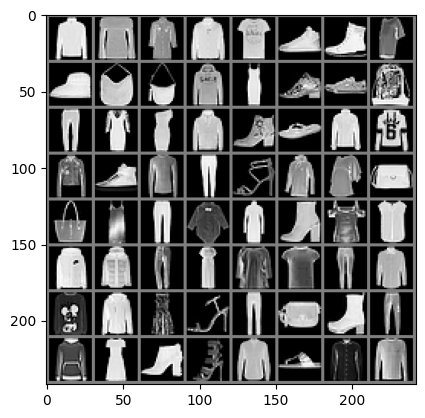

    4     2     6     4     0     7     9     0     9     8     8     2     3     9     7     8     1     3     0     4     9     5     4     2     4     7     2     1     5     2     6     8     8     3     1     6     3     9     6     6     4     4     1     3     3     0     1     6     2     4     3     5     1     8     9     1     2     3     9     5     6     5     6     2


In [8]:
# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))
# Print labels
print(' '.join(f'{labels[j]:5}' for j in range(batch_size)))

In [9]:
############################################################### Functions for Part 1 c) and d) ###############################################################

def set_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')

    elif torch.backends.mps.is_available():
        device = torch.device('mps')

    else:
        device = torch.device('cpu')
    print('Device:', device)

    return device

#-----------------------------------------------------------------------------------------------------

class NeuralNetwork_Exercise1_C(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Linear(784, 256)  # Input size for MNIST is 28x28=784
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc3 = torch.nn.Linear(128, 10)   # 10 output classes for Fashion-MNIST
        self.relu = torch.nn.ReLU()
        self.leaky_relu = torch.nn.LeakyReLU(0.01)

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Define a more complex neural network
class NeuralNetwork_Exercise1_D(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_layer = torch.nn.Linear(784, 256)
        self.fc_128_256 = torch.nn.Linear(128, 256)
        self.fc_256_512 = torch.nn.Linear(256, 512)
        self.fc_128_128 = torch.nn.Linear(128, 128)
        self.fc_256_256 = torch.nn.Linear(256, 256)
        self.fc_512_512 = torch.nn.Linear(512, 512)
        self.fc_512_1024 = torch.nn.Linear(512, 1024)
        self.fc_1024_1024 = torch.nn.Linear(1024, 1024)
        self.fc_1024_2048 = torch.nn.Linear(1024, 2048)
        self.fc_2048_1024 = torch.nn.Linear(2048, 1024)
        self.fc_2048_2048 = torch.nn.Linear(2048, 2048)
        self.fc_1024_512 = torch.nn.Linear(1024, 512)
        self.fc_512_256 = torch.nn.Linear(512, 256)
        self.fc_256_128 = torch.nn.Linear(256, 128)
        self.fc_128_64 = torch.nn.Linear(128, 64)
        self.fc_64_32 = torch.nn.Linear(64, 32)
        self.output_layer = torch.nn.Linear(128, 10)
        self.leaky_relu = torch.nn.LeakyReLU(0.01)
        self.relu = torch.nn.ReLU()
        self.prelu = torch.nn.PReLU()
        self.relu6 = torch.nn.ReLU6()
        self.selu = torch.nn.SELU()
        self.celu = torch.nn.CELU()
        self.gelu = torch.nn.GELU()
        self.silu = torch.nn.SiLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.dropout_10 = torch.nn.Dropout(0.1)
        self.dropout_20 = torch.nn.Dropout(0.2)
        self.dropout_30 = torch.nn.Dropout(0.3)
        self.dropout_40 = torch.nn.Dropout(0.4)
        self.dropout_50 = torch.nn.Dropout(0.5)
        self.dropout_60 = torch.nn.Dropout(0.6)
        self.dropout_70 = torch.nn.Dropout(0.7)
        self.batch_norm2048 = torch.nn.BatchNorm1d(2048)
        self.batch_norm1024 = torch.nn.BatchNorm1d(1024)
        self.batch_norm512 = torch.nn.BatchNorm1d(512)
        self.batch_norm256 = torch.nn.BatchNorm1d(256)
        self.batch_norm128 = torch.nn.BatchNorm1d(128)
        self.batch_norm64 = torch.nn.BatchNorm1d(64)
        self.batch_norm32 = torch.nn.BatchNorm1d(32)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu6(self.batch_norm256(self.input_layer(x)))
        x = self.dropout_70(x)
        x = self.relu6(self.batch_norm128(self.fc_256_128(x)))
        x = self.output_layer(x)
        return x

#-----------------------------------------------------------------------------------------------------
def train_c(model, train_loader, optimizer, loss_func, epochs, device, **kwargs):

    num_epochs = kwargs.get('num_epochs', epochs)
    loss_fn = kwargs.get('loss_fn', loss_func)
    device = kwargs.get('device', device)

    train_loss_hist, train_acc_hist = [], []

    # Add this line to create a plot
    plt.figure(figsize=(10, 5))
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        print('Training phase...')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        pbar = tqdm(enumerate(train_loader), total = len(train_loader))

        for batch_idx, (data, target) in pbar:
            data = data.to(device)
            target = target.to(device)
            model.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            pbar.set_description(f'Loss = {loss:.4f}  |  Accuracy = {100 * correct / total:.2f}% | Batch ID = {batch_idx + 1} ')

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')
        print()

        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_accuracy)

        # Add this line to update the plot
        plt.plot(range(1, epoch + 2), train_loss_hist)

    # Add this line to show the legend and display the plot
    plt.legend()
    plt.show()

    print(f"Cross-Entropy on training set:  {train_loss_hist[-1]:.4f}")
    print(f"Accuracy on training set:       {train_acc_hist[-1]:.2f}%")

    return train_loss_hist, train_acc_hist

def train_d(model, train_loader, optimizer, scheduler, loss_func, epochs, device, **kwargs):

    num_epochs = kwargs.get('num_epochs', epochs)
    loss_fn = kwargs.get('loss_fn', loss_func)
    device = kwargs.get('device', device)

    train_loss_hist, train_acc_hist = [], []
    epoch_list = list(range(1, num_epochs + 1))

    for epoch in epoch_list:
        print(f'Epoch {epoch}/{num_epochs}')

        print('Training phase...')
        model.train()
        train_loss = 0.
        total = 0.
        correct = 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))

        for batch_idx, (data, target) in pbar:
            data = data.to(device)
            target = target.to(device)
            model.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            pbar.set_description(f'Loss = {loss:.4f}  |  Accuracy = {100 * correct / total:.2f}% | Batch ID = {batch_idx + 1} ')

        train_loss /= len(train_loader)
        train_accuracy = 100 * correct / total
        print(f"Learning Rate = {optimizer.param_groups[0]['lr']}")
        print(f'Training Cross-Entropy Loss = {train_loss:.4f}')
        print(f'Training Accuracy = {train_accuracy:.2f}%')
        print()
        scheduler.step(train_loss)

        train_loss_hist.append(train_loss)
        train_acc_hist.append(train_accuracy)

    # Plot the training loss
    plt.figure(figsize=(12, 6))
    plt.plot(epoch_list, train_loss_hist, label='Training Loss', marker='o')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Cross-Entropy on training set:  {train_loss_hist[-1]:.4f}")
    print(f"Accuracy on training set:       {train_acc_hist[-1]:.2f}%")

    return train_loss_hist, train_acc_hist

#-----------------------------------------------------------------------------------------------------

def test(model, test_loader, loss_func, device):

    model.eval()

    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += loss_func(outputs, labels).item()

    test_loss /= len(test_loader)
    test_acc = 100 * correct / total

    print(f"Cross-Entropy on test set: {test_loss:.4f}")
    print(f"Accuracy on test set: {test_acc:.2f}%")

    return test_loss, test_acc



In [10]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root = './data', train = True, download = True, transform = transform)
testset = torchvision.datasets.FashionMNIST(root = './data', train = False, download = True, transform = transform)

TrainLoader = torch.utils.data.DataLoader(trainset, batch_size = 2048, shuffle = True)
TestLoader = torch.utils.data.DataLoader(testset, batch_size = 2048, shuffle = False)

In [11]:
# Initialize the network, loss function, and optimizer
device = set_device()
NeuralNetwork = NeuralNetwork_Exercise1_C().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(NeuralNetwork.parameters(), lr = 0.2)

Device: cpu


## Output 1. (C)

Epoch 1/32
Training phase...


Loss = 1.0628  |  Accuracy = 52.96% | Batch ID = 30 : 100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


Training Cross-Entropy Loss = 1.4009
Training Accuracy = 52.96%

Epoch 2/32
Training phase...


Loss = 0.6778  |  Accuracy = 69.95% | Batch ID = 30 : 100%|██████████| 30/30 [00:11<00:00,  2.57it/s]


Training Cross-Entropy Loss = 0.7878
Training Accuracy = 69.95%

Epoch 3/32
Training phase...


Loss = 0.6573  |  Accuracy = 75.15% | Batch ID = 30 : 100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


Training Cross-Entropy Loss = 0.6481
Training Accuracy = 75.15%

Epoch 4/32
Training phase...


Loss = 0.5244  |  Accuracy = 77.92% | Batch ID = 30 : 100%|██████████| 30/30 [00:17<00:00,  1.69it/s]


Training Cross-Entropy Loss = 0.5882
Training Accuracy = 77.92%

Epoch 5/32
Training phase...


Loss = 0.4942  |  Accuracy = 79.78% | Batch ID = 30 : 100%|██████████| 30/30 [00:17<00:00,  1.67it/s]


Training Cross-Entropy Loss = 0.5407
Training Accuracy = 79.78%

Epoch 6/32
Training phase...


Loss = 0.4601  |  Accuracy = 80.61% | Batch ID = 30 : 100%|██████████| 30/30 [00:11<00:00,  2.54it/s]


Training Cross-Entropy Loss = 0.5229
Training Accuracy = 80.61%

Epoch 7/32
Training phase...


Loss = 0.4772  |  Accuracy = 81.42% | Batch ID = 30 : 100%|██████████| 30/30 [00:11<00:00,  2.56it/s]


Training Cross-Entropy Loss = 0.5017
Training Accuracy = 81.42%

Epoch 8/32
Training phase...


Loss = 0.6038  |  Accuracy = 82.12% | Batch ID = 30 : 100%|██████████| 30/30 [00:11<00:00,  2.57it/s]


Training Cross-Entropy Loss = 0.4841
Training Accuracy = 82.12%

Epoch 9/32
Training phase...


Loss = 0.4905  |  Accuracy = 82.53% | Batch ID = 30 : 100%|██████████| 30/30 [00:13<00:00,  2.27it/s]


Training Cross-Entropy Loss = 0.4694
Training Accuracy = 82.53%

Epoch 10/32
Training phase...


Loss = 0.5021  |  Accuracy = 83.27% | Batch ID = 30 : 100%|██████████| 30/30 [00:14<00:00,  2.13it/s]


Training Cross-Entropy Loss = 0.4551
Training Accuracy = 83.27%

Epoch 11/32
Training phase...


Loss = 0.4515  |  Accuracy = 84.02% | Batch ID = 30 : 100%|██████████| 30/30 [00:19<00:00,  1.55it/s]


Training Cross-Entropy Loss = 0.4336
Training Accuracy = 84.02%

Epoch 12/32
Training phase...


Loss = 0.3922  |  Accuracy = 84.34% | Batch ID = 30 : 100%|██████████| 30/30 [00:14<00:00,  2.02it/s]


Training Cross-Entropy Loss = 0.4242
Training Accuracy = 84.34%

Epoch 13/32
Training phase...


Loss = 0.4594  |  Accuracy = 84.61% | Batch ID = 30 : 100%|██████████| 30/30 [00:11<00:00,  2.52it/s]


Training Cross-Entropy Loss = 0.4190
Training Accuracy = 84.61%

Epoch 14/32
Training phase...


Loss = 0.3869  |  Accuracy = 84.53% | Batch ID = 30 : 100%|██████████| 30/30 [00:11<00:00,  2.56it/s]


Training Cross-Entropy Loss = 0.4187
Training Accuracy = 84.53%

Epoch 15/32
Training phase...


Loss = 0.4020  |  Accuracy = 84.87% | Batch ID = 30 : 100%|██████████| 30/30 [00:12<00:00,  2.42it/s]


Training Cross-Entropy Loss = 0.4107
Training Accuracy = 84.87%

Epoch 16/32
Training phase...


Loss = 0.3915  |  Accuracy = 85.57% | Batch ID = 30 : 100%|██████████| 30/30 [00:12<00:00,  2.42it/s]


Training Cross-Entropy Loss = 0.3937
Training Accuracy = 85.57%

Epoch 17/32
Training phase...


Loss = 0.3662  |  Accuracy = 85.68% | Batch ID = 30 : 100%|██████████| 30/30 [00:13<00:00,  2.23it/s]


Training Cross-Entropy Loss = 0.3905
Training Accuracy = 85.68%

Epoch 18/32
Training phase...


Loss = 0.3937  |  Accuracy = 85.80% | Batch ID = 30 : 100%|██████████| 30/30 [00:14<00:00,  2.04it/s]


Training Cross-Entropy Loss = 0.3902
Training Accuracy = 85.80%

Epoch 19/32
Training phase...


Loss = 0.4557  |  Accuracy = 86.16% | Batch ID = 30 : 100%|██████████| 30/30 [00:14<00:00,  2.01it/s]


Training Cross-Entropy Loss = 0.3790
Training Accuracy = 86.16%

Epoch 20/32
Training phase...


Loss = 0.4077  |  Accuracy = 86.05% | Batch ID = 30 : 100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


Training Cross-Entropy Loss = 0.3794
Training Accuracy = 86.05%

Epoch 21/32
Training phase...


Loss = 0.4151  |  Accuracy = 86.43% | Batch ID = 30 : 100%|██████████| 30/30 [00:12<00:00,  2.37it/s]


Training Cross-Entropy Loss = 0.3702
Training Accuracy = 86.43%

Epoch 22/32
Training phase...


Loss = 0.3596  |  Accuracy = 86.12% | Batch ID = 30 : 100%|██████████| 30/30 [00:12<00:00,  2.40it/s]


Training Cross-Entropy Loss = 0.3744
Training Accuracy = 86.12%

Epoch 23/32
Training phase...


Loss = 0.3405  |  Accuracy = 87.00% | Batch ID = 30 : 100%|██████████| 30/30 [00:19<00:00,  1.57it/s]


Training Cross-Entropy Loss = 0.3557
Training Accuracy = 87.00%

Epoch 24/32
Training phase...


Loss = 0.4205  |  Accuracy = 86.58% | Batch ID = 30 : 100%|██████████| 30/30 [00:12<00:00,  2.41it/s]


Training Cross-Entropy Loss = 0.3640
Training Accuracy = 86.58%

Epoch 25/32
Training phase...


Loss = 0.3201  |  Accuracy = 87.25% | Batch ID = 30 : 100%|██████████| 30/30 [00:16<00:00,  1.82it/s]


Training Cross-Entropy Loss = 0.3483
Training Accuracy = 87.25%

Epoch 26/32
Training phase...


Loss = 0.3286  |  Accuracy = 87.38% | Batch ID = 30 : 100%|██████████| 30/30 [00:14<00:00,  2.05it/s]


Training Cross-Entropy Loss = 0.3441
Training Accuracy = 87.38%

Epoch 27/32
Training phase...


Loss = 0.2754  |  Accuracy = 87.35% | Batch ID = 30 : 100%|██████████| 30/30 [00:14<00:00,  2.09it/s]


Training Cross-Entropy Loss = 0.3429
Training Accuracy = 87.35%

Epoch 28/32
Training phase...


Loss = 0.3454  |  Accuracy = 87.50% | Batch ID = 30 : 100%|██████████| 30/30 [00:14<00:00,  2.10it/s]


Training Cross-Entropy Loss = 0.3392
Training Accuracy = 87.50%

Epoch 29/32
Training phase...


Loss = 0.3194  |  Accuracy = 87.48% | Batch ID = 30 : 100%|██████████| 30/30 [00:14<00:00,  2.02it/s]


Training Cross-Entropy Loss = 0.3415
Training Accuracy = 87.48%

Epoch 30/32
Training phase...


Loss = 0.4076  |  Accuracy = 88.22% | Batch ID = 30 : 100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


Training Cross-Entropy Loss = 0.3249
Training Accuracy = 88.22%

Epoch 31/32
Training phase...


Loss = 0.3141  |  Accuracy = 87.79% | Batch ID = 30 : 100%|██████████| 30/30 [00:12<00:00,  2.48it/s]


Training Cross-Entropy Loss = 0.3302
Training Accuracy = 87.79%

Epoch 32/32
Training phase...


Loss = 0.3000  |  Accuracy = 87.89% | Batch ID = 30 : 100%|██████████| 30/30 [00:12<00:00,  2.47it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Training Cross-Entropy Loss = 0.3288
Training Accuracy = 87.89%



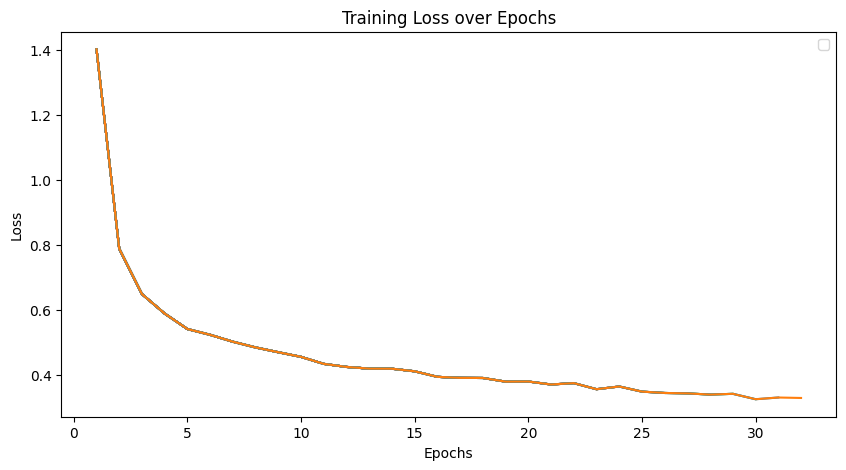

Cross-Entropy on training set:  0.3288
Accuracy on training set:       87.89%


In [12]:
train_loss_hist, train_acc_hist = train_c(NeuralNetwork, TrainLoader, optimizer, criterion, epochs = 32, device = device)

In [13]:
test_loss, test_acc = test(NeuralNetwork, TestLoader, criterion, device)


Cross-Entropy on test set: 0.4099
Accuracy on test set: 85.26%


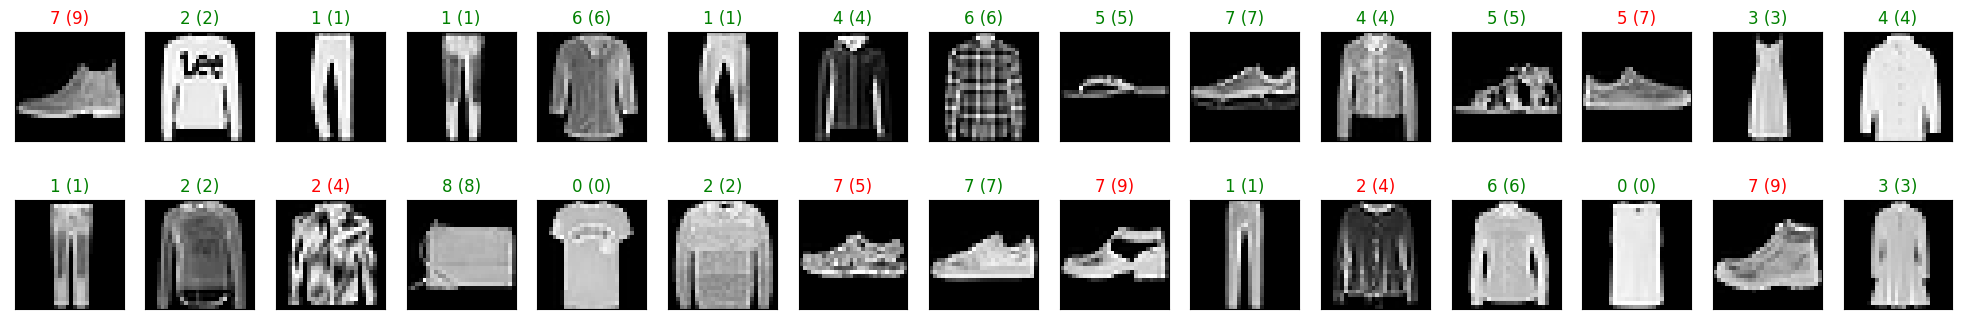

In [14]:
for images, labels in TestLoader:
    break

output = NeuralNetwork(images)

_, preds = torch.max(output, 1)

images = images.numpy()

fig = plt.figure(figsize=(25, 4))

for idx in range(30):
    ax = fig.add_subplot(2, 15, idx + 1, xticks=[], yticks=[])  # Changed 20/2 to 15
    ax.imshow(np.squeeze(images[idx]), cmap='gray')

    # Set the title with predicted and true labels, and color it based on correctness
    title_color = 'green' if preds[idx] == labels[idx] else 'red'
    ax.set_title('{} ({})'.format(str(preds[idx].item()), str(labels[idx].item())), color=title_color)

plt.show()



## Exercise 1. (D)

In [15]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.FashionMNIST(root = './data', train = True, download = True, transform = transform)
testset = torchvision.datasets.FashionMNIST(root = './data', train = False, download = True, transform = transform)

TrainLoader = torch.utils.data.DataLoader(trainset, batch_size = 256, shuffle = True)
TestLoader = torch.utils.data.DataLoader(testset, batch_size = 256, shuffle = False)

In [16]:
# Initialize the network, loss function, and optimizer
device = set_device()
NeuralNetwork_complex = NeuralNetwork_Exercise1_D().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(NeuralNetwork_complex.parameters(), lr = 0.005, weight_decay = 0.001)  # L2 regularization
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 4, gamma = 0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor = 0.5, patience = 1, threshold = 0.02)

Device: cpu


### Output 1. (D)


Epoch 1/64
Training phase...


Loss = 0.5485  |  Accuracy = 77.51% | Batch ID = 235 : 100%|██████████| 235/235 [00:18<00:00, 12.43it/s]


Learning Rate = 0.005
Training Cross-Entropy Loss = 0.6280
Training Accuracy = 77.51%

Epoch 2/64
Training phase...


Loss = 0.5875  |  Accuracy = 80.09% | Batch ID = 235 : 100%|██████████| 235/235 [00:16<00:00, 13.93it/s]


Learning Rate = 0.005
Training Cross-Entropy Loss = 0.5456
Training Accuracy = 80.09%

Epoch 3/64
Training phase...


Loss = 0.4986  |  Accuracy = 80.36% | Batch ID = 235 : 100%|██████████| 235/235 [00:16<00:00, 14.06it/s]


Learning Rate = 0.005
Training Cross-Entropy Loss = 0.5428
Training Accuracy = 80.36%

Epoch 4/64
Training phase...


Loss = 0.5322  |  Accuracy = 80.26% | Batch ID = 235 : 100%|██████████| 235/235 [00:18<00:00, 12.97it/s]


Learning Rate = 0.005
Training Cross-Entropy Loss = 0.5454
Training Accuracy = 80.26%

Epoch 5/64
Training phase...


Loss = 0.4863  |  Accuracy = 82.11% | Batch ID = 235 : 100%|██████████| 235/235 [00:20<00:00, 11.25it/s]


Learning Rate = 0.0025
Training Cross-Entropy Loss = 0.4933
Training Accuracy = 82.11%

Epoch 6/64
Training phase...


Loss = 0.4982  |  Accuracy = 82.39% | Batch ID = 235 : 100%|██████████| 235/235 [00:19<00:00, 12.04it/s]


Learning Rate = 0.0025
Training Cross-Entropy Loss = 0.4866
Training Accuracy = 82.39%

Epoch 7/64
Training phase...


Loss = 0.4376  |  Accuracy = 82.58% | Batch ID = 235 : 100%|██████████| 235/235 [00:19<00:00, 12.00it/s]


Learning Rate = 0.0025
Training Cross-Entropy Loss = 0.4801
Training Accuracy = 82.58%

Epoch 8/64
Training phase...


Loss = 0.3752  |  Accuracy = 82.61% | Batch ID = 235 : 100%|██████████| 235/235 [00:17<00:00, 13.37it/s]


Learning Rate = 0.0025
Training Cross-Entropy Loss = 0.4792
Training Accuracy = 82.61%

Epoch 9/64
Training phase...


Loss = 0.3957  |  Accuracy = 82.78% | Batch ID = 235 : 100%|██████████| 235/235 [00:17<00:00, 13.32it/s]


Learning Rate = 0.0025
Training Cross-Entropy Loss = 0.4797
Training Accuracy = 82.78%

Epoch 10/64
Training phase...


Loss = 0.5556  |  Accuracy = 84.33% | Batch ID = 235 : 100%|██████████| 235/235 [00:18<00:00, 13.02it/s]


Learning Rate = 0.00125
Training Cross-Entropy Loss = 0.4381
Training Accuracy = 84.33%

Epoch 11/64
Training phase...


Loss = 0.3587  |  Accuracy = 84.59% | Batch ID = 235 : 100%|██████████| 235/235 [00:18<00:00, 12.91it/s]


Learning Rate = 0.00125
Training Cross-Entropy Loss = 0.4285
Training Accuracy = 84.59%

Epoch 12/64
Training phase...


Loss = 0.4295  |  Accuracy = 84.65% | Batch ID = 235 : 100%|██████████| 235/235 [00:15<00:00, 15.39it/s]


Learning Rate = 0.00125
Training Cross-Entropy Loss = 0.4244
Training Accuracy = 84.65%

Epoch 13/64
Training phase...


Loss = 0.3832  |  Accuracy = 84.81% | Batch ID = 235 : 100%|██████████| 235/235 [00:14<00:00, 15.86it/s]


Learning Rate = 0.00125
Training Cross-Entropy Loss = 0.4221
Training Accuracy = 84.81%

Epoch 14/64
Training phase...


Loss = 0.5252  |  Accuracy = 85.90% | Batch ID = 235 : 100%|██████████| 235/235 [00:19<00:00, 12.17it/s]


Learning Rate = 0.000625
Training Cross-Entropy Loss = 0.3912
Training Accuracy = 85.90%

Epoch 15/64
Training phase...


Loss = 0.3270  |  Accuracy = 86.21% | Batch ID = 235 : 100%|██████████| 235/235 [00:20<00:00, 11.40it/s]


Learning Rate = 0.000625
Training Cross-Entropy Loss = 0.3802
Training Accuracy = 86.21%

Epoch 16/64
Training phase...


Loss = 0.4012  |  Accuracy = 86.38% | Batch ID = 235 : 100%|██████████| 235/235 [00:18<00:00, 12.59it/s]


Learning Rate = 0.000625
Training Cross-Entropy Loss = 0.3784
Training Accuracy = 86.38%

Epoch 17/64
Training phase...


Loss = 0.3906  |  Accuracy = 86.47% | Batch ID = 235 : 100%|██████████| 235/235 [00:18<00:00, 12.58it/s]


Learning Rate = 0.000625
Training Cross-Entropy Loss = 0.3749
Training Accuracy = 86.47%

Epoch 18/64
Training phase...


Loss = 0.3870  |  Accuracy = 87.41% | Batch ID = 235 : 100%|██████████| 235/235 [00:18<00:00, 12.78it/s]


Learning Rate = 0.0003125
Training Cross-Entropy Loss = 0.3503
Training Accuracy = 87.41%

Epoch 19/64
Training phase...


Loss = 0.2849  |  Accuracy = 87.73% | Batch ID = 235 : 100%|██████████| 235/235 [00:21<00:00, 10.90it/s]


Learning Rate = 0.0003125
Training Cross-Entropy Loss = 0.3439
Training Accuracy = 87.73%

Epoch 20/64
Training phase...


Loss = 0.2859  |  Accuracy = 87.79% | Batch ID = 235 : 100%|██████████| 235/235 [00:17<00:00, 13.19it/s]


Learning Rate = 0.0003125
Training Cross-Entropy Loss = 0.3430
Training Accuracy = 87.79%

Epoch 21/64
Training phase...


Loss = 0.3894  |  Accuracy = 87.82% | Batch ID = 235 : 100%|██████████| 235/235 [00:17<00:00, 13.81it/s]


Learning Rate = 0.0003125
Training Cross-Entropy Loss = 0.3385
Training Accuracy = 87.82%

Epoch 22/64
Training phase...


Loss = 0.4268  |  Accuracy = 88.00% | Batch ID = 235 : 100%|██████████| 235/235 [00:16<00:00, 13.99it/s]


Learning Rate = 0.0003125
Training Cross-Entropy Loss = 0.3372
Training Accuracy = 88.00%

Epoch 23/64
Training phase...


Loss = 0.4321  |  Accuracy = 88.43% | Batch ID = 235 : 100%|██████████| 235/235 [00:16<00:00, 14.22it/s]


Learning Rate = 0.00015625
Training Cross-Entropy Loss = 0.3218
Training Accuracy = 88.43%

Epoch 24/64
Training phase...


Loss = 0.1599  |  Accuracy = 88.74% | Batch ID = 235 : 100%|██████████| 235/235 [00:20<00:00, 11.63it/s]


Learning Rate = 0.00015625
Training Cross-Entropy Loss = 0.3163
Training Accuracy = 88.74%

Epoch 25/64
Training phase...


Loss = 0.4322  |  Accuracy = 88.80% | Batch ID = 235 : 100%|██████████| 235/235 [00:20<00:00, 11.71it/s]


Learning Rate = 0.00015625
Training Cross-Entropy Loss = 0.3149
Training Accuracy = 88.80%

Epoch 26/64
Training phase...


Loss = 0.3396  |  Accuracy = 88.85% | Batch ID = 235 : 100%|██████████| 235/235 [00:20<00:00, 11.71it/s]


Learning Rate = 0.00015625
Training Cross-Entropy Loss = 0.3131
Training Accuracy = 88.85%

Epoch 27/64
Training phase...


Loss = 0.2783  |  Accuracy = 88.98% | Batch ID = 235 : 100%|██████████| 235/235 [00:19<00:00, 12.35it/s]


Learning Rate = 0.00015625
Training Cross-Entropy Loss = 0.3092
Training Accuracy = 88.98%

Epoch 28/64
Training phase...


Loss = 0.3056  |  Accuracy = 89.26% | Batch ID = 235 : 100%|██████████| 235/235 [00:16<00:00, 14.46it/s]


Learning Rate = 7.8125e-05
Training Cross-Entropy Loss = 0.3035
Training Accuracy = 89.26%

Epoch 29/64
Training phase...


Loss = 0.4743  |  Accuracy = 89.45% | Batch ID = 235 : 100%|██████████| 235/235 [00:17<00:00, 13.77it/s]


Learning Rate = 7.8125e-05
Training Cross-Entropy Loss = 0.2976
Training Accuracy = 89.45%

Epoch 30/64
Training phase...


Loss = 0.2943  |  Accuracy = 89.44% | Batch ID = 235 : 100%|██████████| 235/235 [00:16<00:00, 14.08it/s]


Learning Rate = 7.8125e-05
Training Cross-Entropy Loss = 0.2966
Training Accuracy = 89.44%

Epoch 31/64
Training phase...


Loss = 0.2676  |  Accuracy = 89.56% | Batch ID = 235 : 100%|██████████| 235/235 [00:16<00:00, 14.06it/s]


Learning Rate = 7.8125e-05
Training Cross-Entropy Loss = 0.2947
Training Accuracy = 89.56%

Epoch 32/64
Training phase...


Loss = 0.3033  |  Accuracy = 89.41% | Batch ID = 235 : 100%|██████████| 235/235 [00:16<00:00, 14.16it/s]


Learning Rate = 7.8125e-05
Training Cross-Entropy Loss = 0.2974
Training Accuracy = 89.41%

Epoch 33/64
Training phase...


Loss = 0.2585  |  Accuracy = 89.60% | Batch ID = 235 : 100%|██████████| 235/235 [00:17<00:00, 13.16it/s]


Learning Rate = 3.90625e-05
Training Cross-Entropy Loss = 0.2886
Training Accuracy = 89.60%

Epoch 34/64
Training phase...


Loss = 0.2076  |  Accuracy = 89.64% | Batch ID = 235 : 100%|██████████| 235/235 [00:15<00:00, 14.72it/s]


Learning Rate = 3.90625e-05
Training Cross-Entropy Loss = 0.2893
Training Accuracy = 89.64%

Epoch 35/64
Training phase...


Loss = 0.3319  |  Accuracy = 89.66% | Batch ID = 235 : 100%|██████████| 235/235 [00:18<00:00, 12.75it/s]


Learning Rate = 3.90625e-05
Training Cross-Entropy Loss = 0.2879
Training Accuracy = 89.66%

Epoch 36/64
Training phase...


Loss = 0.2983  |  Accuracy = 89.87% | Batch ID = 235 : 100%|██████████| 235/235 [00:20<00:00, 11.20it/s]


Learning Rate = 1.953125e-05
Training Cross-Entropy Loss = 0.2863
Training Accuracy = 89.87%

Epoch 37/64
Training phase...


Loss = 0.3367  |  Accuracy = 89.94% | Batch ID = 235 : 100%|██████████| 235/235 [00:19<00:00, 12.21it/s]


Learning Rate = 1.953125e-05
Training Cross-Entropy Loss = 0.2842
Training Accuracy = 89.94%

Epoch 38/64
Training phase...


Loss = 0.2223  |  Accuracy = 89.85% | Batch ID = 235 : 100%|██████████| 235/235 [00:20<00:00, 11.67it/s]


Learning Rate = 9.765625e-06
Training Cross-Entropy Loss = 0.2848
Training Accuracy = 89.85%

Epoch 39/64
Training phase...


Loss = 0.2294  |  Accuracy = 89.93% | Batch ID = 235 : 100%|██████████| 235/235 [00:18<00:00, 12.57it/s]


Learning Rate = 9.765625e-06
Training Cross-Entropy Loss = 0.2827
Training Accuracy = 89.93%

Epoch 40/64
Training phase...


Loss = 0.2216  |  Accuracy = 89.94% | Batch ID = 235 : 100%|██████████| 235/235 [00:15<00:00, 14.85it/s]


Learning Rate = 9.765625e-06
Training Cross-Entropy Loss = 0.2846
Training Accuracy = 89.94%

Epoch 41/64
Training phase...


Loss = 0.3066  |  Accuracy = 89.92% | Batch ID = 235 : 100%|██████████| 235/235 [00:16<00:00, 14.46it/s]


Learning Rate = 9.765625e-06
Training Cross-Entropy Loss = 0.2831
Training Accuracy = 89.92%

Epoch 42/64
Training phase...


Loss = 0.2260  |  Accuracy = 89.93% | Batch ID = 235 : 100%|██████████| 235/235 [00:20<00:00, 11.52it/s]


Learning Rate = 4.8828125e-06
Training Cross-Entropy Loss = 0.2838
Training Accuracy = 89.93%

Epoch 43/64
Training phase...


Loss = 0.2834  |  Accuracy = 90.01% | Batch ID = 235 : 100%|██████████| 235/235 [00:17<00:00, 13.52it/s]


Learning Rate = 4.8828125e-06
Training Cross-Entropy Loss = 0.2819
Training Accuracy = 90.01%

Epoch 44/64
Training phase...


Loss = 0.2471  |  Accuracy = 90.01% | Batch ID = 235 : 100%|██████████| 235/235 [00:17<00:00, 13.52it/s]


Learning Rate = 2.44140625e-06
Training Cross-Entropy Loss = 0.2795
Training Accuracy = 90.01%

Epoch 45/64
Training phase...


Loss = 0.3097  |  Accuracy = 90.06% | Batch ID = 235 : 100%|██████████| 235/235 [00:23<00:00,  9.90it/s]


Learning Rate = 2.44140625e-06
Training Cross-Entropy Loss = 0.2820
Training Accuracy = 90.06%

Epoch 46/64
Training phase...


Loss = 0.2846  |  Accuracy = 90.04% | Batch ID = 235 : 100%|██████████| 235/235 [00:23<00:00, 10.21it/s]


Learning Rate = 1.220703125e-06
Training Cross-Entropy Loss = 0.2822
Training Accuracy = 90.04%

Epoch 47/64
Training phase...


Loss = 0.2140  |  Accuracy = 90.05% | Batch ID = 235 : 100%|██████████| 235/235 [00:19<00:00, 12.30it/s]


Learning Rate = 1.220703125e-06
Training Cross-Entropy Loss = 0.2808
Training Accuracy = 90.05%

Epoch 48/64
Training phase...


Loss = 0.2115  |  Accuracy = 90.01% | Batch ID = 235 : 100%|██████████| 235/235 [00:18<00:00, 12.90it/s]


Learning Rate = 6.103515625e-07
Training Cross-Entropy Loss = 0.2808
Training Accuracy = 90.01%

Epoch 49/64
Training phase...


Loss = 0.1699  |  Accuracy = 89.97% | Batch ID = 235 : 100%|██████████| 235/235 [00:18<00:00, 12.95it/s]


Learning Rate = 6.103515625e-07
Training Cross-Entropy Loss = 0.2841
Training Accuracy = 89.97%

Epoch 50/64
Training phase...


Loss = 0.3180  |  Accuracy = 89.93% | Batch ID = 235 : 100%|██████████| 235/235 [00:18<00:00, 12.65it/s]


Learning Rate = 3.0517578125e-07
Training Cross-Entropy Loss = 0.2822
Training Accuracy = 89.93%

Epoch 51/64
Training phase...


Loss = 0.3708  |  Accuracy = 90.02% | Batch ID = 235 : 100%|██████████| 235/235 [00:17<00:00, 13.18it/s]


Learning Rate = 3.0517578125e-07
Training Cross-Entropy Loss = 0.2832
Training Accuracy = 90.02%

Epoch 52/64
Training phase...


Loss = 0.3292  |  Accuracy = 89.85% | Batch ID = 235 : 100%|██████████| 235/235 [00:16<00:00, 13.89it/s]


Learning Rate = 1.52587890625e-07
Training Cross-Entropy Loss = 0.2835
Training Accuracy = 89.85%

Epoch 53/64
Training phase...


Loss = 0.3601  |  Accuracy = 89.93% | Batch ID = 235 : 100%|██████████| 235/235 [00:18<00:00, 12.51it/s]


Learning Rate = 1.52587890625e-07
Training Cross-Entropy Loss = 0.2816
Training Accuracy = 89.93%

Epoch 54/64
Training phase...


Loss = 0.3285  |  Accuracy = 89.94% | Batch ID = 235 : 100%|██████████| 235/235 [00:16<00:00, 14.05it/s]


Learning Rate = 7.62939453125e-08
Training Cross-Entropy Loss = 0.2806
Training Accuracy = 89.94%

Epoch 55/64
Training phase...


Loss = 0.2756  |  Accuracy = 89.98% | Batch ID = 235 : 100%|██████████| 235/235 [00:19<00:00, 11.96it/s]


Learning Rate = 7.62939453125e-08
Training Cross-Entropy Loss = 0.2808
Training Accuracy = 89.98%

Epoch 56/64
Training phase...


Loss = 0.2807  |  Accuracy = 89.95% | Batch ID = 235 : 100%|██████████| 235/235 [00:22<00:00, 10.65it/s]


Learning Rate = 3.814697265625e-08
Training Cross-Entropy Loss = 0.2823
Training Accuracy = 89.95%

Epoch 57/64
Training phase...


Loss = 0.2565  |  Accuracy = 90.10% | Batch ID = 235 : 100%|██████████| 235/235 [00:17<00:00, 13.25it/s]


Learning Rate = 3.814697265625e-08
Training Cross-Entropy Loss = 0.2806
Training Accuracy = 90.10%

Epoch 58/64
Training phase...


Loss = 0.3680  |  Accuracy = 90.00% | Batch ID = 235 : 100%|██████████| 235/235 [00:19<00:00, 11.93it/s]


Learning Rate = 1.9073486328125e-08
Training Cross-Entropy Loss = 0.2808
Training Accuracy = 90.00%

Epoch 59/64
Training phase...


Loss = 0.3055  |  Accuracy = 89.81% | Batch ID = 235 : 100%|██████████| 235/235 [00:17<00:00, 13.07it/s]


Learning Rate = 1.9073486328125e-08
Training Cross-Entropy Loss = 0.2830
Training Accuracy = 89.81%

Epoch 60/64
Training phase...


Loss = 0.2395  |  Accuracy = 89.88% | Batch ID = 235 : 100%|██████████| 235/235 [00:18<00:00, 13.00it/s]


Learning Rate = 1.9073486328125e-08
Training Cross-Entropy Loss = 0.2827
Training Accuracy = 89.88%

Epoch 61/64
Training phase...


Loss = 0.3079  |  Accuracy = 90.06% | Batch ID = 235 : 100%|██████████| 235/235 [00:19<00:00, 11.92it/s]


Learning Rate = 1.9073486328125e-08
Training Cross-Entropy Loss = 0.2840
Training Accuracy = 90.06%

Epoch 62/64
Training phase...


Loss = 0.3043  |  Accuracy = 90.09% | Batch ID = 235 : 100%|██████████| 235/235 [00:16<00:00, 14.21it/s]


Learning Rate = 1.9073486328125e-08
Training Cross-Entropy Loss = 0.2798
Training Accuracy = 90.09%

Epoch 63/64
Training phase...


Loss = 0.2357  |  Accuracy = 89.97% | Batch ID = 235 : 100%|██████████| 235/235 [00:16<00:00, 14.44it/s]


Learning Rate = 1.9073486328125e-08
Training Cross-Entropy Loss = 0.2794
Training Accuracy = 89.97%

Epoch 64/64
Training phase...


Loss = 0.3478  |  Accuracy = 89.88% | Batch ID = 235 : 100%|██████████| 235/235 [00:16<00:00, 14.27it/s]


Learning Rate = 1.9073486328125e-08
Training Cross-Entropy Loss = 0.2823
Training Accuracy = 89.88%



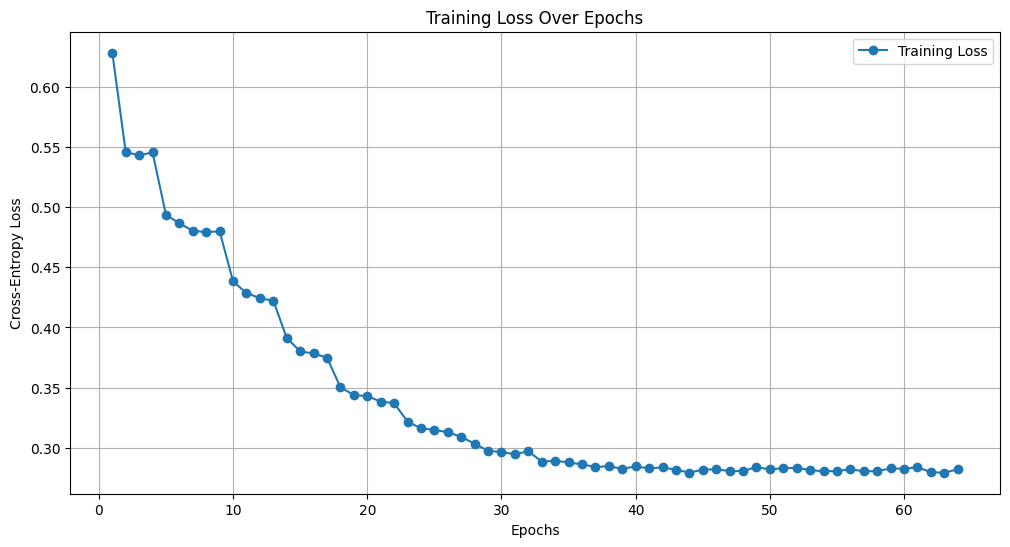

Cross-Entropy on training set:  0.2823
Accuracy on training set:       89.88%


In [17]:
train_loss_hist, train_acc_hist = train_d(NeuralNetwork_complex, TrainLoader, optimizer, scheduler, criterion, epochs = 64, device = device)

To improve the previous feedforward neural network for the Fashion-MNIST classification task, we implemented the following changes:

**Use a Learning Rate Scheduler**: One of the most, if not the most important hyper-parameter in a neural network is the learning rate. This choice is very important, and in fact affects a lot the results given by the network. The problem with a constant learning rate is that it doesn't adapt to the training stage, because in the beginning the learning rate can be higher because the network still has a lot to learn, and therefore the updates made by the optimizer can be bigger; however, when the network is converging, a smaller learning rate is better suited because larger steps will make the network wand around the local minimum, but never reaches it. To deal with this, we applied a learning rate scheduler, which changes the learning rate's value during training, adapting it depending on the training stage.

**Use Different Optimizer**: Previously we used Stochastic Gradient Descent as our optimizer, however there're more algorithms that, theoretically, converge even faster than a simple SDG. Some examples are Root Meas Square propagation (RMSprop) and Adaptive Moment (Adam), or even SGD with momentum (Nesterov or not). These algorithms are more interesting because they use exponential smoothing to make the gradients focus on pointing more towards the local minimum. This, combined with a good learning rate trategy can make a model very powerfull!

**Use Different Activation Function**: We tested several activation function, for example ReLU, Leaky ReLU, and Sigmoid, in order to check how different activation functions impact not only the training loss, but also how well certain activation functions can help the network generalize better.

**Variance vs Bias**: Although activation functions can improve the results, we wanted to reduce overfitting as much as possible, while also keeping the network from underfitting, and for that we used two techniques specifically created to deal with overfitting, which are regularization techniques and dropout layers.

**Batch Normalization**: It's usual to normalize the input data before training or testing a neural network, so that the data's different scales don't affect the importance the network gives to certain inputs in detriment of others that might be as much, or even more important. Therefore, it also makes sense to normalize the values computed by the network during training. So, by applying batch normalization we can help the network stabilize and converge faster to a local minimum.

**Change Epoch Number and Mini-Batch Size**: Another two important hyper-paramters are epochs and the mini-batch size. The size of the mini-batch affects the training time of the network, but also enables the optimizer to be applied more or less times, per epoch, and this can make the model learn more in less epochs. The number of epochs is also important because after a certain ammount of epochs the model might still be learning, so in order for it to converge more epochs might be required.

**Increase Network Complexity**: We can add more hidden layers and neurons to increase the network's capacity to learn complex patterns in the data, helping reduce overfitting.

In [18]:
test_loss, test_acc = test(NeuralNetwork_complex, TestLoader, criterion, device)

Cross-Entropy on test set: 0.3022
Accuracy on test set: 88.98%


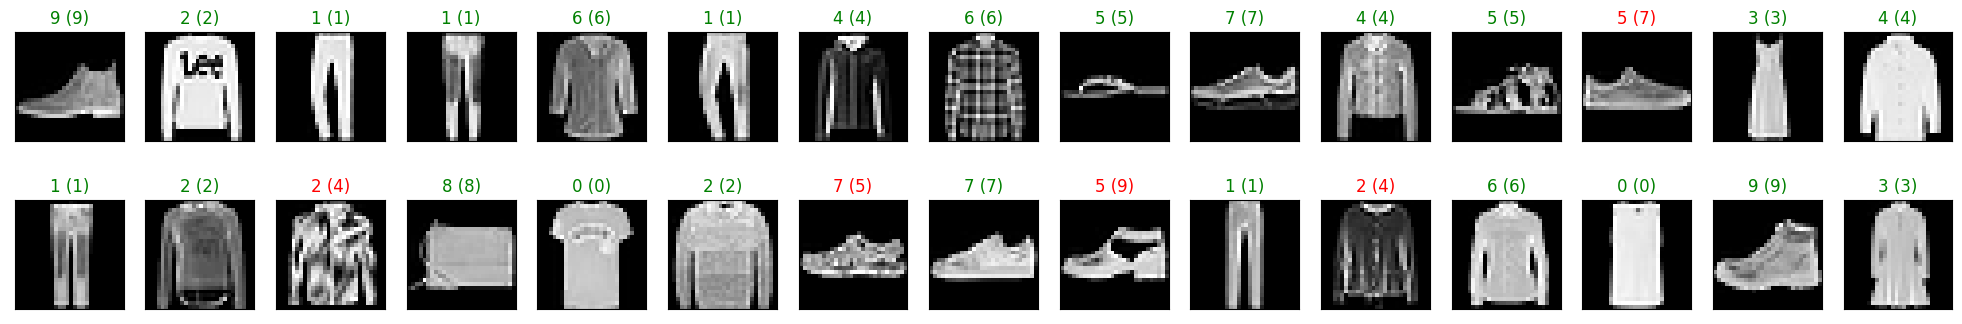

In [19]:
for images, labels in TestLoader:
    break

output = NeuralNetwork_complex(images)

_, preds = torch.max(output, 1)

images = images.numpy()

fig = plt.figure(figsize=(25, 4))

for idx in range(30):
    ax = fig.add_subplot(2, 15, idx + 1, xticks=[], yticks=[])  # Changed 20/2 to 15
    ax.imshow(np.squeeze(images[idx]), cmap='gray')

    # Set the title with predicted and true labels, and color it based on correctness
    title_color = 'green' if preds[idx] == labels[idx] else 'red'
    ax.set_title('{} ({})'.format(str(preds[idx].item()), str(labels[idx].item())), color=title_color)

plt.show()

### Explaining results

**Use a Learning Rate Scheduler**: The individual results changed depending on what was being tested, however, in general, the usage of a learning rate scheduler significantly improved the network's hability to not jump between worse and better training losses by reducing the learning rate during training. For example, without a learning rate scheduler a the cross-binary loss couldn't get lower than a loss of 0.33, but with this strategy the loss crossed the 0.30 barrier quite easily. This strategy, combined with others, enabled the test loss to get lower or bery close to 0.30, something that in c) not even the network was able to achieve in its training loss.

**Use Different Optimizer**: The usage of different (and more robust) optimizers definetely made a huge difference in the results. SGD without any momentum component underfitted the data given the poor results in comparison with this network. Given the tests made, Adam was the best optimizer, followed by RMSprop and SGD with momentum. Although the difference between Adam and RMSprop wasn't that great, the fact is that RMSprop wasn't able to cross certain thresholds that only Adam could in terms of training and test loss. For example, in a specific experiment RMSprop couldn't get past a training loss of 0.29, always between 0.295 and 0.291, however Adam was able get values near 0.28, and sometimes even got training losses lower than 0.28. Although overfitted, the best test loss result ever seen was achieved with Adam, with a test loss of 0.2771.

**Use Different Activation Function**: We tested more than five activation functions, however the best ones were ReLU6, PReLU, Leaky ReLU and ReLU. All these activation functions give similar results, however the perception we got was that although Leaky ReLU was getting marginally better results than ReLU, the best activation function found was ReLU6. This was an interesting finding because this is a ReLU activation function, however it has a maximum value of 6.

**Variance vs Bias**: This was the topic where we worked the most. We tried not to change the architecture from c) too much, in order to see how the results changed by only adding dropout layers and L2 regularization. The results were quite significant... Of course, we could easy achieve a training accuracy and loss of 99% and 0.02, respectively, but existed a huge overfitting problem. So, we tested with different dropout rates and, in fact, this increase made the overfitting problem reduce, and then the lambda from the L2 regularization gave the final touches. Still, the network's achitecture and all other changes described here changed the overfitting level, so we were constantly adapting the dropout layers and lambda. Overall, we were very happy with the results gotten, with practically no overfit existing.

**Batch Normalization**: There isn't much to say in this regard. The fact is that batch normalization is something that should always be used in a neural network, and here was no exception.

**Change Epoch Number and Mini-Batch Size**: The mini-batch size significantly changed the results. We tested from 64 to 2048, however the best results were found with a mini-batch size of 256. Regaring the number epochs, this was always changing, and in fact, we can say that the number of epochs should be between 40 and 64.

**Increase Network Complexity**: We didn't try much to change the architecture because we wanted to keep it close to the one from c), however we increased by one hidden layer comparing with the previous network, but results didn't change much.

## Exercise 1, e)

Looking at both architectures, it's visible that Network A is deeper and has less neurons in each hidden layer, than Network B. That being said, this simple choice of the architecture truly affects a model's predictive power. That being said, Network A is better than Ntework B for several reasons:

1. **Representation Power**: Deeper neural networks have more layers, which means they can learn more complex representations of the input data. Each neuron in the first hidden layer can learn a different feature of the data, and the subsequent layers can combine these features, from all neurons from the previous hidden layer, to learn even more complex representations by combining this elementary features into more complete ones. This allows the network to capture more intricate patterns in the data, leading to better performance. In other words, we can say that Network A is able to start by learning initial underlying factors of variation of the target, and for the subsequent layers these variation factors are taken (or not) into consideration in order to detect more complex variation factors that better explain the function to which we're apporximating.

2. **Generalization**: Deeper neural networks are less likely to overfit the training data than shallow networks. This is because deeper networks have more parameters, which allows them to learn more complex functions that can better fit the training data. Goodfellow et al. (2014d) showed, in a multi-digit numbers dataset, that the depth of a neural network constantly increased the network's accuracy, going from around 92.5% to 96%. This means that Network A should be able to generalize better on test data than Network B.

3. **Efficiency**: Deeper neural networks can be more efficient than shallow networks in terms of the number of parameters required to achieve a certain level of performance. This is because deeper networks can use fewer parameters per layer, since each layer only needs to learn a small part of the overall function. This can lead to faster training times and lower memory requirements. So, we can also assume that Network A might be faster to train that Network B.